# DEADLINE NOVEMBER 4

Shapes of objects

You now work in a chocolate factory and through image analysis you will have to distinguish Non Stops from M&Ms.

You will work on the image IMG_2754_nonstop_alltogether.JPG  in this exercise.

Try to use techniques that we have worked on so far during the course. Describe all the steps you go through to obtain you results, include images your code and explanations for what you do.

Hand in the report on Canvas by Nov 4th 2022.

 
- process:
    - binary image(Object black, background-0)
    - mask=binary+ original (background will be gone)



In [2]:
from skimage.morphology import skeletonize, dilation, opening, square, disk
from skimage.morphology import remove_small_holes, remove_small_objects # for filling the holes and denoising
import matplotlib.pyplot as plt

import numpy as np
import math
from skimage import io


from skimage.filters import threshold_mean#for binarising
from skimage.filters import try_all_threshold
from skimage.filters import threshold_otsu, threshold_minimum, threshold_triangle, threshold_mean


# For watershed
from scipy import ndimage as ndi#for distance
from skimage.feature import peak_local_max 
from skimage.segmentation import watershed 
from skimage import measure #measure objects


# for making boxex around the chocolates
from matplotlib.patches import Rectangle

In [3]:
def get_image(name):
    """ Using the skimage.io import the image with the file name.
    This function returns the gray image as numpy array """
    
    #Getting the image  
    #filename = '../Images/'+name
    filename = name
    image_gray = io.imread(filename, as_gray = True) 
    image_RGB = io.imread(filename, as_gray = False) 
    
    return image_gray, image_RGB

In [4]:
def show_image(image, label ="Image:", size=(6,2), cmap='viridis'):
    """This function shows/plots the given image."""
    plt.subplots(1,1,figsize=size)
    plt.title(label = label, fontsize=12)
    plt.imshow(image, cmap=cmap) 
    plt.axis('off')
    plt.show()

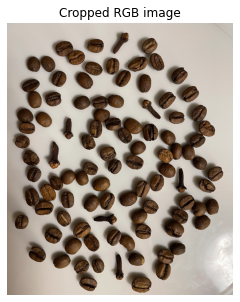

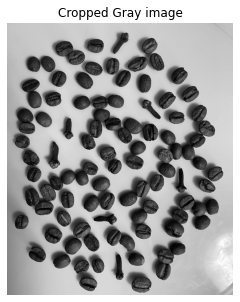

In [5]:
image_gray, image_RGB = get_image("coffeebeans.jpg")
# show_image(image_gray, "Original Binary image")

#cropping the head
image_gray = image_gray[300:3660, 110:2900]    #[Row Y, COL, X]
image_RGB = image_RGB[300:3660, 110:2900]   #[Row Y, COL, X]

show_image(image_RGB, label ="Cropped RGB image", size=(10,5))
show_image(image_gray, label ="Cropped Gray image", size=(10,5), cmap='gray')

In [6]:
# fig, ax = try_all_threshold(image_gray, figsize=(20, 18), verbose=False)
# plt.show()

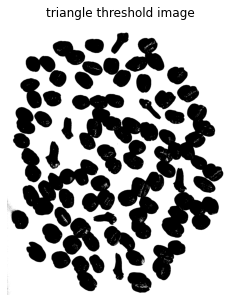

In [7]:
#binarising using triangle filter
thresh = threshold_otsu(image_gray)
binary_otsu = image_gray > thresh
show_image(binary_otsu, "triangle threshold image", (12,5), cmap='gray')

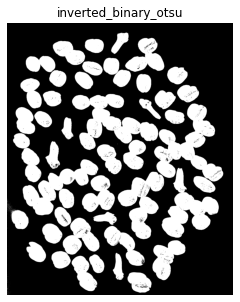

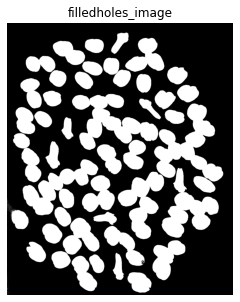

In [8]:
# fill holes
inverted_binary_otsu = np.invert(binary_otsu)
show_image(inverted_binary_otsu, "inverted_binary_otsu", (12,5), cmap='gray')
holes_filled = remove_small_holes(inverted_binary_otsu, area_threshold = 7000)
show_image(holes_filled, "filledholes_image", (12,5), cmap='gray')

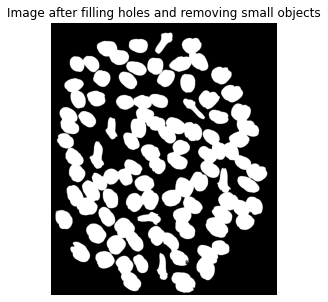

In [9]:
#removing noise
filled_denoised_image = remove_small_objects(holes_filled, 1000)
show_image(filled_denoised_image, "Image after filling holes and removing small objects", (12,5), cmap='gray')

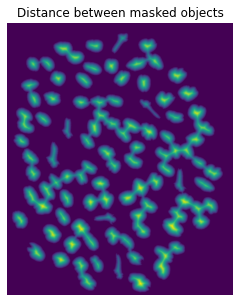

In [10]:
#watershed to sepratae objects

#Distance map: Distance between masked objects
distance = ndi.distance_transform_edt(filled_denoised_image) 
show_image(distance, "Distance between masked objects", (12,5))


In [11]:
import warnings #To ignore a futurewarning about indices
warnings.simplefilter(action ='ignore', category=FutureWarning)

no of objects detected: 87


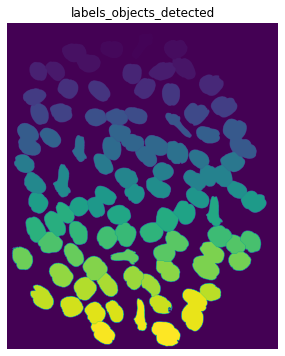

In [12]:
#watershed using distance map
#setting the min distance to 100: Using min_distance in peak_local_max to ensure that local peaks are not to close
local_maxi = peak_local_max(distance, 
                            min_distance = 150, 
                            indices = False, 
                            footprint = np.ones((30,30)), 
                            labels = filled_denoised_image.astype(int))
markers = ndi.label(local_maxi)[0]
labels_objects_detected = watershed(-distance, markers, mask = filled_denoised_image, watershed_line = True)
print("no of objects detected:", len(np.unique(labels_objects_detected)))
show_image(labels_objects_detected, "labels_objects_detected", (10,6))


In [13]:
#measure objects
labels2 = measure.label(labels_objects_detected)

properties = measure.regionprops(labels2)
print(f'Amount of objects in image: {len(properties)}')

Amount of objects in image: 86


eccentricityfloat
Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.

axis_major_lengthfloat
The length of the major axis of the ellipse that has the same normalized second central moments as the region.

Number of beans 78


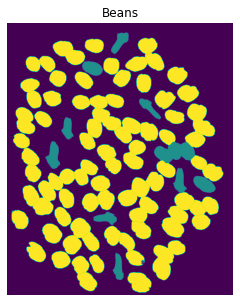

In [14]:
#Finding the beans

truncated_beans = [prop for prop in properties if (prop.eccentricity<=0.901
                                                           and prop.area>=15000 
                                                           and prop.major_axis_length >= 80)]

print("Number of beans", len(truncated_beans))


image_beans = filled_denoised_image[:,:]*1
for obj in truncated_beans:
    for coord in obj.coords:
        image_beans[coord[0], coord[1]] = 2

show_image(image_beans, "Beans", (12,5))

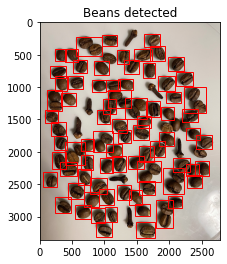

In [15]:
#Adding red rectangles around beans
rectangles = []

for obj in truncated_beans:
    X_values = []
    Y_values = []
    for coord in obj.coords:
        X_values.append(coord[0])
        Y_values.append(coord[1])
    min_x = min(X_values)
    min_y = min(Y_values)
    max_x = max(X_values)
    max_y = max(Y_values)
    rectangles.append((min_y, min_x, max_y-min_y, max_x-min_x,))


for rec in rectangles:
    plt.gca().add_patch(Rectangle((rec[0],rec[1]),
                                  rec[2],rec[3],
                                  edgecolor='red',
                                  facecolor='none',
                                  lw=1))

plt.imshow(image_RGB , cmap='gray')
plt.title(label = "Beans detected", fontsize=12)
plt.show()

Number of cloves 7


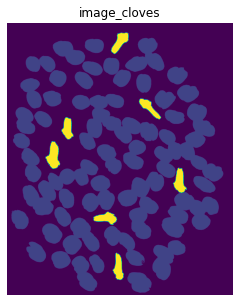

In [16]:
#Finding cloves in image

cloves = [prop for prop in properties if prop.eccentricity>=0.8
                                                           and prop.major_axis_length >=280
                                                           and  prop.area<55000 ]

print("Number of cloves", len(cloves))


# image_MM = dilation(filled_denoised_image, footprint = np.ones((2,2)))
image_cloves = filled_denoised_image[:,:]*1
for obj in cloves:
    for coord in obj.coords:
        image_cloves[coord[0], coord[1]] = 5

show_image(image_cloves, "image_cloves", (14,5))


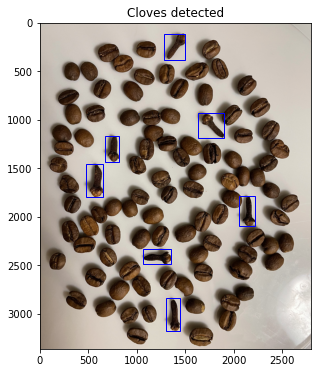

In [17]:
#Adding red rectangles around cloves
rectangles = []

for obj in cloves:
    X_values = []
    Y_values = []
    for coord in obj.coords:
        X_values.append(coord[0])
        Y_values.append(coord[1])
    min_x = min(X_values)
    min_y = min(Y_values)
    max_x = max(X_values)
    max_y = max(Y_values)
    rectangles.append((min_y, min_x, max_y-min_y, max_x-min_x,))


plt.subplots(1,1,figsize= (12, 6))
for rec in rectangles:
    plt.gca().add_patch(Rectangle((rec[0],rec[1]),
                                  rec[2],rec[3],
                                  edgecolor='blue',
                                  facecolor='none',
                                  lw=1))

plt.imshow(image_RGB)
plt.title(label = "Cloves detected", fontsize=12)
plt.show()

# Identfication of all
- blue=cloves
- Red= beans

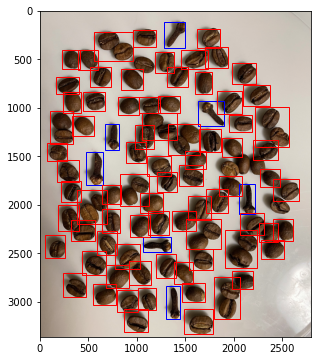

In [18]:
#Adding red rectangles around cloves
rectangles = []

for obj in cloves:
    X_values = []
    Y_values = []
    for coord in obj.coords:
        X_values.append(coord[0])
        Y_values.append(coord[1])
    min_x = min(X_values)
    min_y = min(Y_values)
    max_x = max(X_values)
    max_y = max(Y_values)
    rectangles.append((min_y, min_x, max_y-min_y, max_x-min_x,))


plt.subplots(1,1,figsize= (12, 6))
for rec in rectangles:
    plt.gca().add_patch(Rectangle((rec[0],rec[1]),
                                  rec[2],rec[3],
                                  edgecolor='blue',
                                  facecolor='none',
                                  lw=1))

# plt.imshow(image_RGB)
# plt.title(label = "Cloves detected", fontsize=12)
# plt.show()


#Adding red rectangles around beans
rectangles = []

for obj in truncated_beans:
    X_values = []
    Y_values = []
    for coord in obj.coords:
        X_values.append(coord[0])
        Y_values.append(coord[1])
    min_x = min(X_values)
    min_y = min(Y_values)
    max_x = max(X_values)
    max_y = max(Y_values)
    rectangles.append((min_y, min_x, max_y-min_y, max_x-min_x,))


for rec in rectangles:
    plt.gca().add_patch(Rectangle((rec[0],rec[1]),
                                  rec[2],rec[3],
                                  edgecolor='red',
                                  facecolor='none',
                                  lw=1))

plt.imshow(image_RGB, cmap='gray')
plt.show()